prefill
decode
optimize: kv cache - fasten computation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

In [3]:
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

In [4]:
!ls -l ./models/gpt2

ls: ./models/gpt2: No such file or directory


In [6]:
!ls ~/.cache/huggingface/hub/

datasets--cais--mmlu
models--BAAI--bge-small-en
models--EleutherAI--gpt-j-6b
models--EleutherAI--pythia-410m
models--Salesforce--SFR-Embedding-2_R
models--Salesforce--SFR-Embedding-Mistral
models--Salesforce--blip-image-captioning-base
models--Salesforce--codegen-2B-mono
models--Salesforce--codegen2-7B
models--Salesforce--codegen25-7b-multi
models--Salesforce--codet5-base
models--Salesforce--xLAM-v0.1-r
models--Salesforce--xgen-7b-8k-base
models--TinyLlama--TinyLlama-1.1B-Chat-v1.0
models--Writer--palmyra-small
models--bert-base-cased
models--bert-base-cased-finetuned-mrpc
models--bert-base-uncased
models--camembert-base
models--deepseek-ai--DeepSeek-R1-Distill-Qwen-32B
models--deepset--bert-base-cased-squad2
models--distilbert--distilbert-base-uncased-finetuned-sst-2-english
models--distilbert-base-cased
models--distilbert-base-cased-distilled-squad
models--distilbert-base-uncased
models--distilbert-base-uncased-finetuned-sst-2-english
models--distilroberta-base
models--facebook--bart

In [7]:
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


In [9]:
text = "Hello, how are you?"
tokens = tokenizer.tokenize(text)
print(tokens)

['Hello', ',', 'Ġhow', 'Ġare', 'Ġyou', '?']


In [10]:
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(token_ids)

[15496, 11, 703, 389, 345, 30]


In [11]:
token_ids = tokenizer.encode(text)
print(token_ids)

[15496, 11, 703, 389, 345, 30]


In [12]:
tokens = tokenizer.convert_ids_to_tokens(token_ids)
print(tokens)

['Hello', ',', 'Ġhow', 'Ġare', 'Ġyou', '?']


In [15]:
tokenizer.decode(token_ids)

'Hello, how are you?'

### Text Generation

In [22]:
prompt = "The quick brown fox jumped over the"
inputs = tokenizer(prompt, return_tensors="pt")
inputs

{'input_ids': tensor([[  464,  2068,  7586, 21831, 11687,   625,   262]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

#### 
 - Pass the inputs to the model and retrieve the logits to find the most likely next token

In [24]:
with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
print(logits.shape)

torch.Size([1, 7, 50257])


In [32]:
last_token_logits = logits[:,-1, :]
next_token_id = last_token_logits.argmax()
next_token_id
print(last_token_logits)
print(next_token_id)

tensor([[-92.9352, -92.3160, -96.0634,  ..., -95.3959, -96.1432, -94.6931]])
tensor(13990)


In [28]:
# Get the predicted token
predicted_token_id = torch.argmax(last_token_logits, dim=-1)
print(predicted_token_id)
predicted_word = tokenizer.decode(predicted_token_id)
print(predicted_word)

tensor([13990])
 fence


In [30]:
## Generate a Full Sentence (Autoregressive )
generated_ids = model.generate(**inputs)
generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
print(generated_text)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The quick brown fox jumped over the fence and ran to the other side of the fence. He was about to run when he saw the


#### 
- print the 10 most likely words

In [31]:
top_k  = torch.topk(last_token_logits, k = 10)
tokens = [tokenizer.decode(tk) for tk in top_k.indices]
tokens

[' fence edge railing wall table tree top counter ground side']

#### 

- Concatenate the input and most likely tokens

In [33]:
next_inputs = {
    "input_ids": torch.cat(
      [inputs["input_ids"], next_token_id.reshape((1,1))], dim=1  
    ),
    "attention_mask" : torch.cat(
        [inputs["attention_mask"], torch.tensor([[1]])], dim =1
    )
}

print(next_inputs["input_ids"],  next_inputs["input_ids"].shape)
print(next_inputs["attention_mask"],
      next_inputs["attention_mask"].shape)

tensor([[  464,  2068,  7586, 21831, 11687,   625,   262, 13990]]) torch.Size([1, 8])
tensor([[1, 1, 1, 1, 1, 1, 1, 1]]) torch.Size([1, 8])


## Prefill and decode : optimizing token genearation over multiple steps

In [66]:
n = 500

In [67]:
def generate_token(inputs):
    with torch.no_grad():
        outputs = model(**inputs)
        
        logits = outputs.logits
        last_logits = logits[0, -1, :]
        next_token_id = last_logits.argmax()
        return next_token_id
    

In [68]:
generated_tokens = []
next_inputs = inputs
durations_s = []
for _ in range(n):
    t0 = time.time()
    next_token_id = generate_token(next_inputs)
    durations_s += [time.time() - t0]
    
    next_inputs = {
        "input_ids" : torch.cat(
            [next_inputs["input_ids"], next_token_id.reshape((1,1))], dim=1
        ),
        "attention_mask" : torch.cat(
            [next_inputs['attention_mask'], torch.tensor([[1]])], dim=1
        ),
    }
    
    next_token = tokenizer.decode(next_token_id)
    generated_tokens.append(next_token)
    
print(f"{sum(durations_s)} s")
print(generated_text)

65.36854243278503 s
The quick brown fox jumped over the fence and ran to the other side of the fence. He was about to run when he saw the


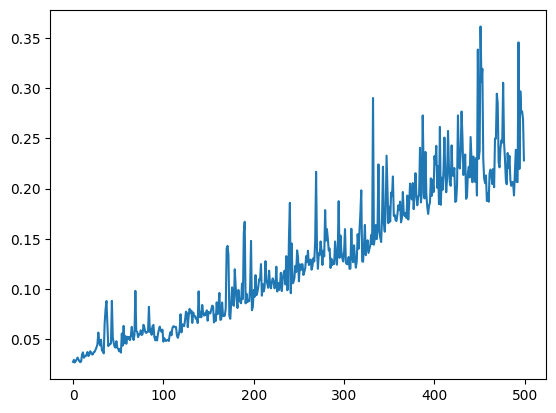

In [69]:
plt.plot(durations_s)
plt.show()

## Speeding up text generation with KV Caching

### KV caching is a technique to speed up token generation by stroing some of the tensors in the attention head for use in subsequent generation steps

- Modify the generate helper function to return the next token and the key/value tensors

In [70]:
def generate_token_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    return next_token_id, outputs.past_key_values

In [71]:
generated_tokens = []
next_inputs = inputs
durations_cached_s = []
for _ in range(n):
    t0 = time.time()
    next_token_id, past_key_values = \
        generate_token_with_past(next_inputs)
    durations_cached_s += [time.time() - t0]
    
    next_inputs = {
        "input_ids": next_token_id.reshape((1, 1)),
        "attention_mask": torch.cat(
            [next_inputs["attention_mask"], torch.tensor([[1]])],
            dim=1),
        "past_key_values": past_key_values,
    }
    
    next_token = tokenizer.decode(next_token_id)
    generated_tokens.append(next_token)

print(f"{sum(durations_cached_s)} s")
print(generated_tokens)

11.499929904937744 s
[' fence', ' and', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence', '.', ' He', ' was', ' about', ' to', ' run', ' when', ' he', ' saw', ' the', ' fox', '.', ' He', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence', ' and', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence', '.', ' He', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence', ' and', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence', '.', ' He', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence', ' and', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence', '.', ' He', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence', ' and', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence', '.', ' He', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence', ' and', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence', '.', ' He', ' ran', ' to', ' the', ' o

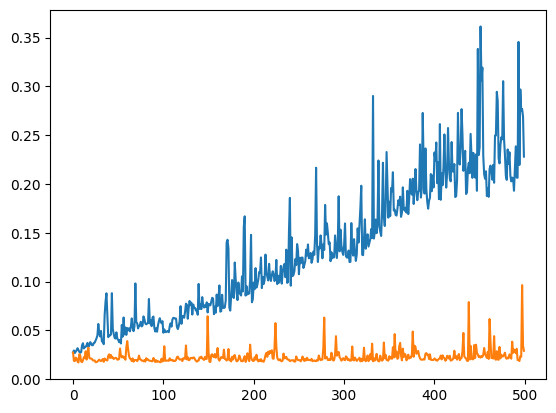

In [72]:
plt.plot(durations_s)
plt.plot(durations_cached_s)
plt.show()